In [1]:
import sys
sys.path.append("..")

import nest_asyncio
nest_asyncio.apply()

from tqdm import trange

In [2]:
from utils.reader import get_yaml_path, read_file
from utils.dict import rename_inner_keys, combine_inner_dict

In [3]:
from evaluation.agent_evaluation import evaluate

2025-11-25 11:14:19.695124: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 11:14:20.326324: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 11:14:24.211654: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
from utils.plotting import plot_all_q_agent

# Descrizione del probema

Il task di obstacle avoidance consiste nel far muovere uno o più agenti all'interno di un ambiente 2D evitando di collidere con gli ostacoli fissi presenti.
L'obiettivo dell'agente è quello di effettuare il maggior numero di passi possibile senza collidere con gli ostacoli.

## Ambiente

L'ambiente è una griglia 2D di dimensioni variabili (5x5, 20x20, 30x30 metri) in cui sono presenti ostacoli rettangolari di dimensioni variabili disposti in posizioni casuali e con orientamenti casuali.
Oltre agli ostacoli, nell'ambiente sono presenti anche uno o più agenti circolari di raggio fisso (0.25 metri) che si muovono all'interno dell'ambiente.

### Osservazioni

Ogni agente osserva l'ambiente circostante sfruttando gli input di 8 sensori di prossimità disposti intorno ad esso in modo uniforme (ogni 45 gradi).
Ogni sensore restituisce la distanza normalizzata (tra 0 e 1) dall'ostacolo più vicino nella direzione del sensore, con 1 che indica nessun ostacolo entro la portata massima del sensore (1 metro) e 0 che indica una collisione immediata.
I sensori di luce ambientale non sono considerati in questo task, così come il sensore GPS.

### Azioni

L'agente si muove all'interno dell'ambiente impostando la velocità delle due ruote indipendenti (sinistra e destra).
In entrambe le soluzioni implementate, le azioni sono discrete e consistono in una combinazione di velocità predefinite per le due ruote.
Le possibili azioni sono:

- *avanti*: entrambe le ruote alla massima velocità (1.0);
- *rotazione leggera a sinistra*: ruota sinistra a velocità minima (0.0), ruota destra alla massima velocità (1.0);
- *rotazione leggera a destra*: ruota sinistra alla massima velocità (1.0), ruota destra a velocità minima (0.0);
- *rotazione sul posto a sinistra*: ruota sinistra a velocità negativa (-1.0), ruota destra alla massima velocità (1.0);
- *rotazione sul posto a destra*: ruota sinistra alla massima velocità (1.0), ruota destra a velocità negativa (-1.0).

## Definizione di successo

Un episodio è considerato di successo se l'agente riesce a evitare collisioni con gli ostacoli per un numero massimo di passi.
Il numero di passi dipende dalla dimensione dell'ambiente:

- ambiente 5x5 metri: 5000 passi;
- ambiente 20x20 metri: 20000 passi;
- ambiente 30x30 metri: 30000 passi.

## Valutazione

La valutazione delle performance dell'agente viene effettuata andando a calcolare la percentuale di episodi completati con successo su un totale di 100 episodi di valutazione.
Ogni episodio di valutazione ha una configurazione dell'ambiente diversa, con ostacoli posizionati casualmente.
Le 100 configurazioni sono suddivise in:

- 50 configurazioni di ambienti piccoli (5x5 metri);
- 30 configurazioni di ambienti medi (20x20 metri);
- 20 configurazioni di ambienti grandi (30x30 metri).

Questa suddivisione permette di valutare l'adattabilità dell'agente a diverse complessità ambientali. Gli ambienti di dimensioni minori sono generalmente più difficili da navigare a causa della maggiore densità di ostacoli.

Vengono quindi calcolate le seguenti metriche:

- **Success rate**: percentuale di episodi completati con successo;
- **Average steps**: numero medio di passi effettuati prima della collisione o del completamento dell'episodio;
- **TD loss**: calcolato solamente per l'algoritmo DQ-Learning, rappresenta la *temporal difference loss* media durante l'episodio in analisi.

## Analisi errori

Le metriche sopra descritte permettono di identificare le aree in cui l'agente ha difficoltà.
Valori differenti di *success rate* in ambienti di diverse dimensioni possono indicare problemi di adattabilità dell'agente.
Nel caso del DQ-Learning, un alto valore di *TD loss* può indicare che l'agente non sta apprendendo in modo efficace dalle esperienze passate.
Viene inoltre effettuata un'analisi della *moving average reward* per ogni configurazione ambientale, al fine di identificare eventuali pattern di apprendimento o difficoltà specifiche legate a determinate configurazioni. Questo permette di identificare loop comportamentali o situazioni in cui l'agente tende a fallire ripetutamente.
Per confermare le ipotesi emerse dall'analisi quantitativa, vengono eseguite delle sessioni di debug visivo in cui si osserva il comportamento dell'agente in situazioni specifiche.

# Q-Learning

Il task di obstacle avoidance è stato affrontato inizialmente utilizzando un agente basato su Q-Learning.

## Import delle librerie

In [5]:
from environment.qlearning.obstacle_avoidance_env import ObstacleAvoidanceEnv as QOAEnv
from agent.qagent import QAgent

## Connessione all'ambiente

In [6]:
server_address = "localhost:50051"
client_name = "RLClient"
env = QOAEnv(server_address, client_name)
env.connect_to_client()

2025-11-25 11:14:25,906 — INFO — ✓ Connected to localhost:50051



## Problemi riscontrati

Durante lo svolgimento del task è stato necessario affrontare diversi problemi legati principalmente alla definizione della funzione di reward e alla gestione dello spazio delle osservazioni.

## Azioni

Inizialmente, l'agente disponeva di sole tre azioni: andare avanti, girare a sinistra e destra sul posto.

Queste azioni si sono rivelate sufficienti per permettere all'agente di muoversi, ma limitavano la sua capacità di navigare efficacemente l'ambiente.

Successivamente, sono state introdotte due azioni aggiuntive di rotazione leggera a sinistra e destra, che hanno permesso all'agente di effettuare manovre più fluide e migliorare la navigazione.

```python
self.actions = [
    (1.0, 1.0),  # forward
    (1.0, -1.0),  # left
    (-1.0, 1.0),  # right
    (1.0, 0.0),  # soft right
    (0.0, 1.0),  # soft left
]
```

## Osservazioni

Si è deciso di utilizzare le letture dei sensori di prossimità come osservazioni per l'agente.
In un primo momento, si è effettuata una discretizzazione delle letture di tutti gli 8 sensori in 3 livelli (vicino, medio, lontano), ottenendo uno spazio delle osservazioni di dimensioni elevate (3^8 = 6561 stati). Disponendo inoltre di 3 o 5 azioni, la dimensione della tabella Q risultava essere troppo grande per essere gestita efficacemente.

Dato che le azioni del robot influenzano principalmente i sensori frontali, si è deciso di ridurre lo spazio delle osservazioni considerando solo i 3 sensori frontali (315°, 0°, 45°).
Per ognuno di questi sensori, si è inizialmente mantenuta la discretizzazione in 3 livelli, ottenendo uno spazio delle osservazioni di dimensioni più gestibili (3^3 = 27 stati).
Successivamente, si è deciso di aumentare la granularità della discretizzazione a 4 livelli (`molto vicino`, `vicino`, `medio`, `lontano`), ottenendo uno spazio delle osservazioni di 64 stati (4^3), che ha permesso un miglior apprendimento da parte dell'agente.

```python
def _encode_observation(
    self, proximity_values, light_values, position, orientation
):
    bins = []
    values = [
        proximity_values[0],
        proximity_values[1],
        proximity_values[7],
    ]
    for val in values:
        if val < 0.1:
            bins.append(0)
        elif val < 0.3:
            bins.append(1)
        elif val < 0.6:
            bins.append(2)
        else:
            bins.append(3)

    # Convert to unique state ID
    state = 0
    for i, b in enumerate(bins):
        state += b * (self._bin_values**i)
    return state
```

## Reward

### Prima versione

La prima funzione di reward realizzata era molto semplice e premiava l'agente con 0.1 punti per ogni passo effettuato senza collisioni e penalizzava con -100 punti in caso di collisione.
Le azioni che l'agente poteva compiere in questa prima versione erano limitate a tre: andare avanti, girare a sinistra e girare a destra.
Questa configurazione iniziale ha portato a risultati insoddisfacenti, con l'agente che ruotava su se stesso senza navigare efficacemente l'ambiente.

Per ovviare a questo problema, sono stati introdotti un premio di 0.5 punti per ogni movimento in avanti e una penalità di -0.1 punti per le azioni di rotazione.
Questa soluzione ha permesso all'agente di cominciare a muoversi nell'ambiente, ma il comportamento risultante era ancora subottimale, con l'agente che tendeva a non evitare gli ostacoli, preferendo invece di andare avanti fino alla collisione.

Un tentativo di miglioramento è stato fatto aumentando la penalità per le collisioni a -1000 punti, ma questo ha portato l'agente a ruotare su se stesso senza mai avanzare, cercando di evitare la penalità.

### Seconda versione

La seconda versione della funzione di reward ha introdotto un sistema più sofisticato, basato sulle letture dei sensori di prossimità.
In questa versione, l'agente riceve diverse ricompense:

- `clearance_reward`: una ricompensa che assume valori positivi o negativi sulla base della distanza dagli ostacoli rilevata dai sensori. Minore è la distanza, maggiore è la penalità. Inoltre, viene considerato anche lo spostamento dell'agente tra un passo e l'altro, premiando i movimenti che aumentano la distanza dagli ostacoli e penalizzando ulteriormente quelli che la riducono;
- `collision_penalty`: una penalità significativa (-1000 punti) in caso di collisione con un ostacolo;
- `movement_reward`: che assume valori sulla base di alcune specifiche condizioni legate al movimento dell'agente, andando a premiare movimenti in avanti e penalizzare le rotazioni.

Questa funzione di reward più complessa ha permesso all'agente di apprendere un comportamento più efficace, riuscendo a navigare l'ambiente evitando gli ostacoli in modo più efficiente, anche se in particolari situazioni l'agente tendeva a bloccarsi in loop comportamentali.

## Configurazioni ambienti

Per gli addestramenti sono stati realizzati ambienti di dimensioni 10x10 metri, con un numero di ostacoli variabile tra 5 e 15, posizionati in modo casuale.
Si è scelto di utilizzare ambienti di dimensioni intermedie in quanto questi hanno permesso di effettuare addestramenti più rapidi rispetto agli ambienti più grandi, pur mantenendo una complessità sufficiente per l'apprendimento dell'agente.
Nonostante ciò, l'agente è stato in grado di generalizzare il comportamento appreso anche in ambienti più grandi e più piccoli durante la fase di valutazione.

Inizialmente, per massimizzare la varietà delle esperienze durante l'addestramento, si è deciso di generare un numero di configurazioni ambientali molto elevato (10000 configurazioni diverse).
In questo modo, ad ogni episodio di addestramento l'agente si trovava ad affrontare un ambiente differente, favorendo l'apprendimento di strategie più generali per l'evitamento degli ostacoli.
Inoltre, questi ambienti non sono stati selezionati manualmente, ma generati in modo casuale, quindi alcuni di essi potevano risultare particolarmente difficili da navigare a causa della disposizione degli ostacoli.
Questi problemi hanno reso l'addestramento meno efficace, poiché l'agente faticava a trovare strategie valide in ambienti troppo complessi.
L'agente infatti tendeva a dimenticare alcuni comportamenti positivi appresi in precedenza a fronte di situazioni difficili incontrate ripetutamente.

Successivamente si è deciso di ridurre il numero di configurazioni ambientali a 300, selezionate manualmente in modo da coprire una varietà di scenari.
Buona parte di queste configurazioni sono state scelte in quanto permettevano all'agente di muoversi agevolmente all'inizio, per poi incontrare ostacoli più complessi.
Questo approccio ha permesso all'agente di apprendere strategie più efficaci per l'evitamento degli ostacoli, oltre a rendere l'addestramento più stabile e veloce.

## Approccio risolutivo

Di seguito sono descritte le componenti principali dell'approccio risolutivo basato su Q-Learning.

### Reward

La funzione di reward utilizzata è un'evoluzione della seconda versione descritta in precedenza, con alcune modifiche per migliorare ulteriormente il comportamento dell'agente.
In particolare la componente `movement_reward` è stata migliorata con le seguenti regole:

- se l'agente non si sposta (rotazione sul posto), allora riceve una penalità di -1 punto, solo se la distanza dagli ostacoli è superiore al livello `molto vicino` (0.1 metri), altrimenti riceve 0.5 punti;
- se l'agente effettua una rotazione leggera (a sinistra o destra) quando la distanza dagli ostacoli è superiore al livello `medio` (0.5 metri), allora riceve una penalità di -1 punto, altrimenti riceve 1 punto;
- se l'agente si muove in avanti allora riceve 2 punti.

In questo modo, l'agente ottiene ricompense fatte su misura rispetto a come viene effettuata la codifica delle osservazioni.
Questa maggiore connessione tra osservazioni, azioni e reward ha ridotto notevolmente i casi in cui l'agente si bloccava in loop comportamentali, migliorando l'efficacia complessiva dell'apprendimento.

### Termination

La terminazione dell'episodio avviene solamente in caso di collisione con un ostacolo.

### Truncation

L'episodio viene troncato quando l'agente raggiunge il numero massimo di passi consentiti per l'ambiente in cui si trova.

### Q-Agent

L'agente utilizza i seguenti iperparametri:

- epsilon-max: 1.0
- epsilon-min: 0.001
- alpha: 0.01
- gamma: 0.99

Il decay di epsilon avviene in modo esponenziale, questo permette di mantenere un alto livello di esplorazione nelle prime fasi dell'addestramento, per poi ridurlo gradualmente mano a mano che l'agente acquisisce esperienza.

L'addestramento è stato effettuato per un totale di 3000 episodi. Durante l'addestramento, quando la `moving average reward` migliorava, veniva salvata una copia del modello dell'agente. Questo ha permesso di controllare i progressi dell'apprendimento e di mantenere una versione stabile dell'agente.

In [7]:
agent = QAgent(env)
agent_id = "00000000-0000-0000-0000-000000000001"
agents = {agent_id: agent}

#### Caricamento agente salvato

In [8]:
path = get_yaml_path("src", "scripts", "resources", "generated", "checkpoints", "obstacle-avoidance", "q-learning", "oa_final")
agent.load(path)
print("Agent hyperparameters:")
print(f"\tEpsilon-max: {agent.epsilon_max}")
print(f"\tEpsilon-min: {agent.epsilon_min}")
print(f"\tAlpha: {agent.alpha}")
print(f"\tGamma: {agent.gamma}")

2025-11-25 11:14:25,923 — INFO — Agent loaded from /home/simone/uni-lab/PPS/2024/SRS/PPS-22-srs/docs/obstacle-avoidance/python/src/scripts/resources/generated/checkpoints/obstacle-avoidance/q-learning/oa_final.npz
2025-11-25 11:14:25,923 — INFO —   Q-table shape: (64, 5)
2025-11-25 11:14:25,924 — INFO —   Current epsilon: 0.0020
2025-11-25 11:14:25,924 — INFO —   Total episodes trained: 3000
Agent hyperparameters:
	Epsilon-max: 1.0
	Epsilon-min: 0.001
	Alpha: 0.01
	Gamma: 0.99


### Valutazione delle performance

#### Caricamento degli ambienti di valutazione

In [9]:
# 5x5 configurations
config_5_path = get_yaml_path("src", "scripts", "resources", "generated", "evaluation", "obstacle-avoidance", "5x5")
yml_files_5 = sorted(config_5_path.glob("*.yml"), key=lambda p: p.name)
configs_5 = [read_file(yml) for yml in yml_files_5]

# 20x20 configurations
config_20_path = get_yaml_path("src", "scripts", "resources", "generated", "evaluation", "obstacle-avoidance", "20x20")
yml_files_20 = sorted(config_20_path.glob("*.yml"), key=lambda p: p.name)  
configs_20 = [read_file(yml) for yml in yml_files_20]

# 30x30 configurations
config_30_path = get_yaml_path("src", "scripts", "resources", "generated", "evaluation", "obstacle-avoidance", "30x30")
yml_files_30 = sorted(config_30_path.glob("*.yml"), key=lambda p: p.name)  
configs_30 = [read_file(yml) for yml in yml_files_30]

#### Creazione della funzione di valutazione

Questa funzione viene utilizzata per valutare se l'agente ha completato con successo un episodio di valutazione.

In questo caso, l'episodio è considerato di successo se l'agente riesce a evitare collisioni con gli ostacoli per il numero massimo di passi consentiti per l'ambiente in cui si trova.
Il controllo della reward serve solamente nel caso in cui l'episodio sia troncato nello stesso passo in cui avviene la collisione.

In [10]:
did_succeed=lambda reward, termination, truncation: True if truncation and reward > -500 else False

#### Valutazione dell'agente

In [11]:
final_results_5 = evaluate(env=env, agents=agents, configs=configs_5, max_steps=5000, did_succeed=did_succeed)
# final_results_20 = evaluate(env=env, agents=agents, configs=configs_20, max_steps=20000, did_succeed=did_succeed)
# final_results_30 = evaluate(env=env, agents=agents, configs=configs_30, max_steps=30000, did_succeed=did_succeed)

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:52<00:00,  2.25s/configuration run]


In [12]:
final_results_5 = rename_inner_keys(final_results_5, {agent_id: "final"})
# final_results_20 = rename_inner_keys(final_results_20, {agent_id: "final"})
# final_results_30 = rename_inner_keys(final_results_30, {agent_id: "final"})

#### Caricamento di un agente ad un episodio precedente

Viene caricato l'agente salvato ad un episodio precedente durante il training per confrontarne i risultati

In [13]:
path = get_yaml_path("src", "scripts", "resources", "generated", "checkpoints", "obstacle-avoidance", "q-learning", "oa_ep884")
agent.load(path)
print("Agent hyperparameters:")
print(f"\tEpsilon-max: {agent.epsilon_max}")
print(f"\tEpsilon-min: {agent.epsilon_min}")
print(f"\tAlpha: {agent.alpha}")
print(f"\tGamma: {agent.gamma}")

2025-11-25 11:16:18,286 — INFO — Agent loaded from /home/simone/uni-lab/PPS/2024/SRS/PPS-22-srs/docs/obstacle-avoidance/python/src/scripts/resources/generated/checkpoints/obstacle-avoidance/q-learning/oa_ep884.npz
2025-11-25 11:16:18,286 — INFO —   Q-table shape: (64, 5)
2025-11-25 11:16:18,287 — INFO —   Current epsilon: 0.1318
2025-11-25 11:16:18,287 — INFO —   Total episodes trained: 884
Agent hyperparameters:
	Epsilon-max: 1.0
	Epsilon-min: 0.001
	Alpha: 0.01
	Gamma: 0.99


In [14]:
prev_results_5 = evaluate(env=env, agents=agents, configs=configs_5, max_steps=5000, did_succeed=did_succeed)
# prev_results_20 = evaluate(env=env, agents=agents, configs=configs_20, max_steps=20000, did_succeed=did_succeed)
# prev_results_30 = evaluate(env=env, agents=agents, configs=configs_30, max_steps=30000, did_succeed=did_succeed)

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.54s/configuration run]


In [15]:
prev_results_5 = rename_inner_keys(prev_results_5, {agent_id: "prev"})
# prev_results_20 = rename_inner_keys(prev_results_20, {agent_id: "prev"})
# prev_results_30 = rename_inner_keys(prev_results_30, {agent_id: "prev"})

In [16]:
results_5 = combine_inner_dict(final_results_5, prev_results_5)
# results_20 = combine_inner_dict(final_results_20, prev_results_20)
# results_30 = combine_inner_dict(final_results_30, prev_results_30)

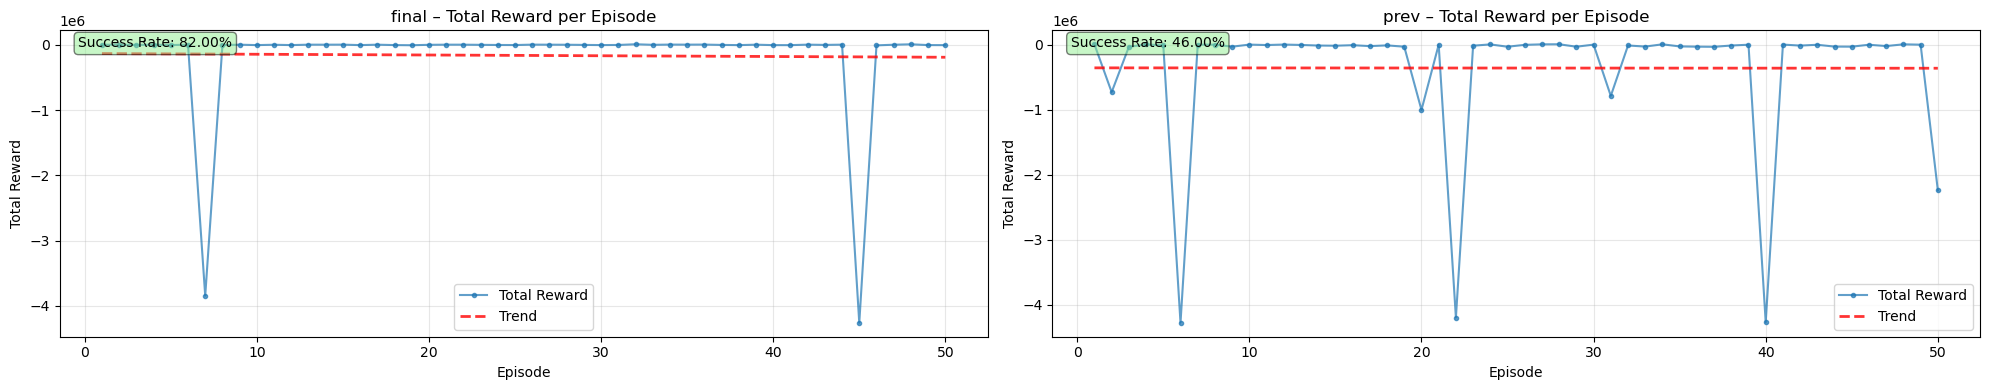

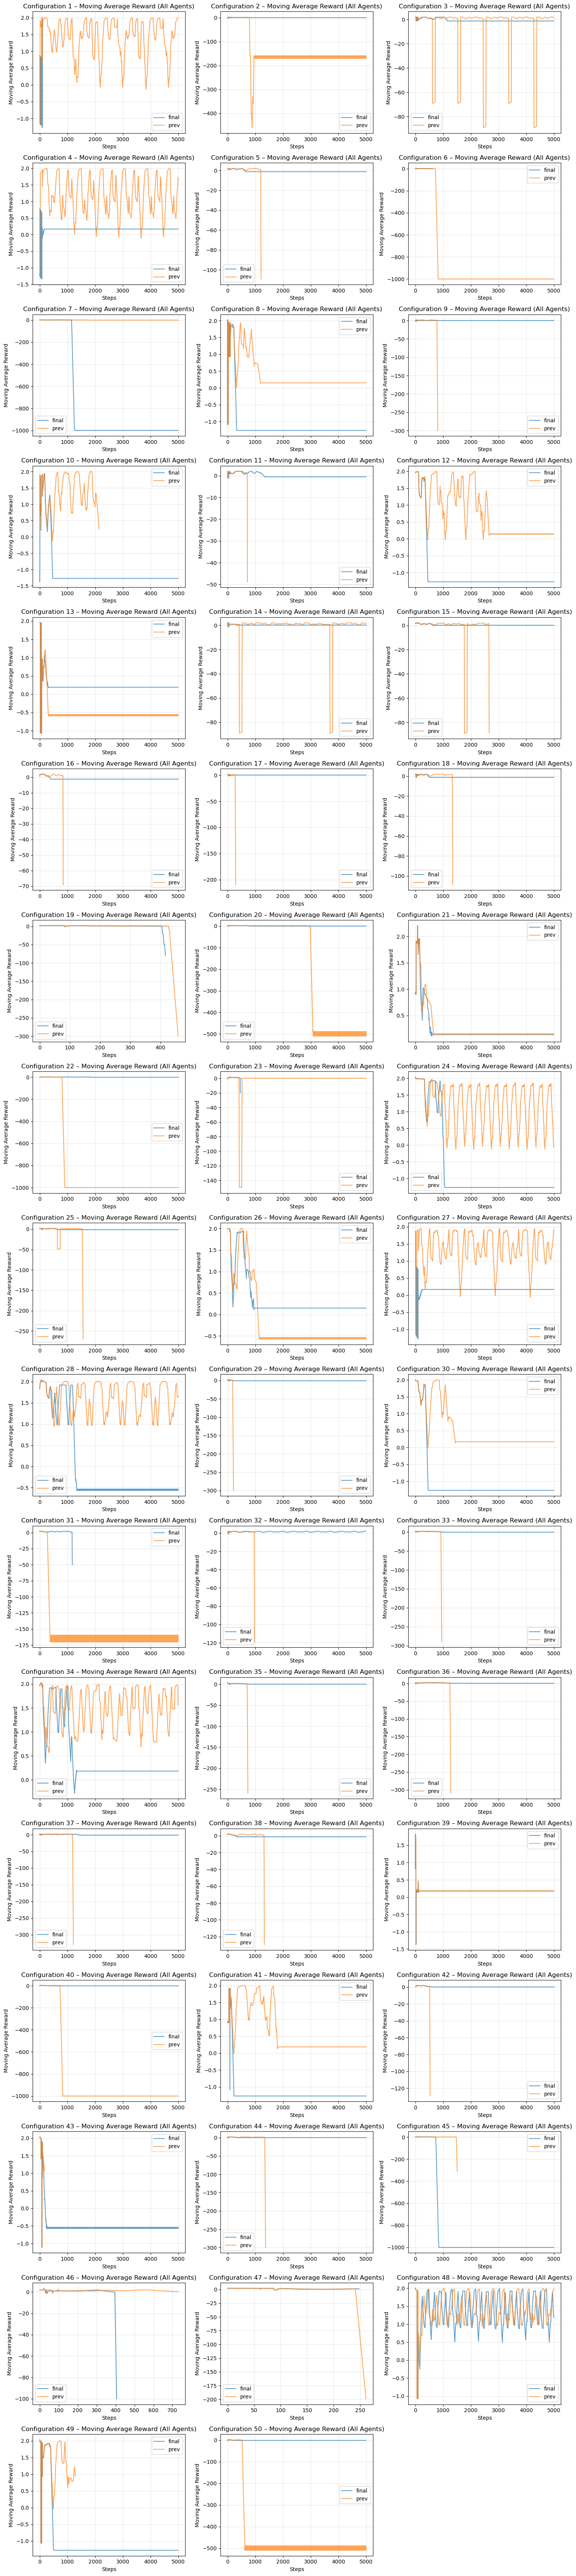

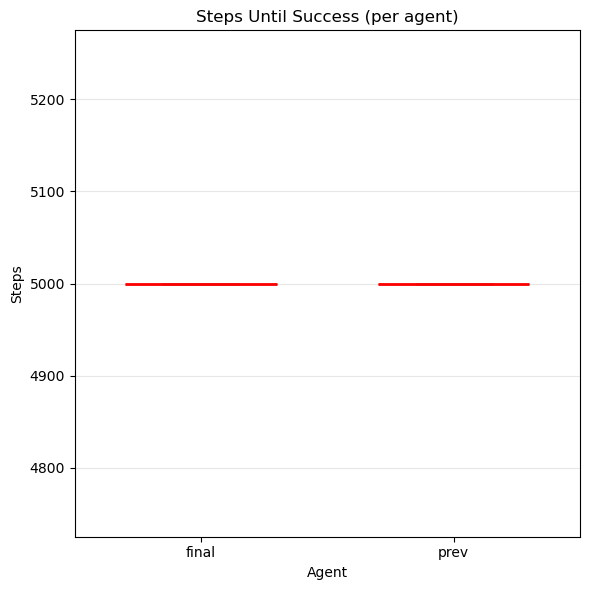

In [17]:
plot_all_q_agent(results_5, agents=["final", "prev"])
# plot_all_q_agent(results_20, agents=["final", "prev"])
# plot_all_q_agent(results_30, agents=["final", "prev"])


### Analisi errori

#### Success rate per dimensione ambiente

Dai risultati sopra mostrati, si può osservare come, in entrambi i checkpoint caricati, l'agente ottiene un successo che non dipende significativamente dalla dimensione dell'ambiente.
Questo indica che l'agente è stato in grado di generalizzare il comportamento appreso durante l'addestramento, effettuato in ambienti 10x10 metri.
Un dato interessante è che l'agente indicato come "final" ottiene un successo decisamente migliore rispetto all'agente salvato nel checkpoint precedente, a prima vista sembra che l'apprendimento sia progredito in modo significativo tra i due checkpoint.
Tuttavia, un'analisi più approfondita della *moving average reward* durante la valutazione mostra che l'agente "final" si trova più spesso in situazioni nelle quali esegue ripetutamente le stesse azioni senza fare progressi, indicando la presenza di loop comportamentali.

#### Moving average reward durante la valutazione

Ovviamente, per il task in esame, non è possibile analizzare la *median steps to success* in quanto gli episodi di valutazione non terminano mai con successo prima del raggiungimento del numero massimo di passi.

È però possibile ottenere informazioni significative analizzando la *moving average reward* durante la valutazione. Si nota infatti che l'agente salvato nel checkpoint precedente si mostra meno soggetto a loop comportamentali rispetto all'agente "final".
Per questo motivo, nonostante l'agente "final" abbia un successo complessivamente migliore, l'agente del checkpoint precedente potrebbe essere considerato più robusto in termini di comportamento.

##### Analisi visiva del comportamento

<!-- TODO: inserire gif dei comportamenti degli agenti in situazioni specifiche -->
Come si può osservare sopra, l'agente "final" tende a bloccarsi anche in situazioni relativamente semplici.
Questo comportamento è probabilmente dovuto al fatto che l'agente ha appreso a massimizzare la reward in situazioni specifiche, ma non è riuscito a sviluppare strategie generali per evitare gli ostacoli in modo efficace.
Al contrario, l'agente salvato nel checkpoint precedente mostra un comportamento più stabile nelle stesse situazioni, entrando in loop comportamentali solamente in scenari più complessi.

##### Loop comportamentali

I loop comportamentali si manifestano in situazioni in cui l'agente si trova intrappolato in una serie di azioni ripetitive che non portano a progressi significativi nell'evitare gli ostacoli.
Questi loop avvengono per sequenze di azioni, e relative osservazioni, che si ripetono ciclicamente, del tipo:

- `[act_1, obs_1] -> [act_2, obs_2] -> [act_3, obs_3] -> [act_1, obs_1] -> [act_2, obs_2] -> ...`

Nella maggior parte dei casi, questi loop si verificano in situazioni in cui l'agente si trova vicino a ostacoli o in spazi ristretti, dove le opzioni di movimento sono limitate.
Dato che l'agente utilizza un approccio basato su Q-Learning è impossibile per lui uscire da questi loop una volta che si sono instaurati.

Quando l'agente entra in un loop comportamentale, la *moving average reward* tende a stabilizzarsi a valori negativi, la penalità totale ricevuta durante il loop supera la penalità per la collisione.
Questo dettaglio è importante in quanto indica che l'agente non sta semplicemente evitando la collisione, ma si trova effettivamente in una situazione di stallo.

Date le limitazioni intrinseche del Q-Learning, risulta difficile eliminare completamente questi loop comportamentali.

#### Commenti finali

In conclusione, l'agente basato su Q-Learning ha mostrato buone capacità di apprendimento e generalizzazione del comportamento di evitamento degli ostacoli, nonostante la presenza di loop comportamentali in alcune situazioni.
Tecniche più avanzate, come l'uso di reti neurali per approssimare la funzione Q, sono mostrate successivamente e hanno permesso di superare alcune delle limitazioni riscontrate con l'approccio basato su tabelle Q.

# DQ-Learning

Il task di obstacle avoidance è stato successivamente affrontato utilizzando un agente basato su Deep Q-Learning (DQN).

Questo approccio ha permesso di superare alcune delle limitazioni riscontrate con l'agente basato su Q-Learning, in particolare per quanto riguarda la gestione di spazi di osservazione più complessi e la capacità di generalizzazione.

Si è sfruttata come base la soluzione implementata per il Q-Agent, mantenendo inizialmente la stessa funzione di reward, le stesse azioni e configurazioni ambientali.

## Import delle librerie

In [24]:
from environment.deepqlearning.obstacle_avoidance_env import ObstacleAvoidanceEnv as DQOAEnv
from agent.scala_dqagent import DQAgent
from training.dqnetwork import DQNetwork

## Connessione all'ambiente

In [21]:
server_address = "localhost:50051"
client_name = "RLClient"
dq_env = DQOAEnv(server_address, client_name)
dq_env.connect_to_client()

2025-11-25 11:18:52,222 — INFO — ✓ Connected to localhost:50051



## Problemi riscontrati

Durante lo svolgimento del task, il principale problema riscontrato è stato legato alla definizione della funzione di reward.

Il DQ-Agent aveva una percentuale di successo molto più bassa rispetto al Q-Agent, circa il 10% contro il 50% del Q-Agent.
Questo comportamento, osservando visivamente il comportamento dell'agente, era dovuto al fatto che esso tendeva a restare molto vicino agli ostacoli, di conseguenza spesso collidendo con gli spigoli degli stessi.

Una seconda problematica inizialmente riscontrata era legata alla capacità dell'agente di generalizzare il comportamento appreso in situazioni diverse da quelle viste durante l'addestramento. Questo problema era dovuto alla configurazione della rete neurale utilizzata per approssimare la funzione Q, la quale disponeva di un singolo layer nascosto con 8 neuroni. Questa architettura si è rivelata insufficiente per catturare la complessità del task.

## Configurazioni ambienti

Per gli addestramenti sono stati utilizzati gli stessi ambienti descritti per il Q-Agent, in modo da poter confrontare direttamente le performance dei due agenti.

Sono state effettuate alcune prove sia con un numero elevato di configurazioni ambientali (10000) sia con un numero ridotto (300), riscontrando caratteristiche diverse rispetto a quanto osservato con il Q-Agent, che saranno descritte in seguito.

Come verrà descritto nella sezione riguardante la reward utilizzata, l'agente ha mostrato difficoltà inizialmente nel mantenere una distanza adeguata dagli ostacoli, portando a numerose collisioni.
Le differenti configurazioni ambientali hanno avuto un impatto significativo su questo comportamento, in particolare:

- con un numero elevato di configurazioni ambientali, generate casualmente, l'agente presentava difficoltà maggiori nel mantenere una buona distanza dagli ostacoli, preferendo mantenersi vicino ad essi. Un comportamento particolare osservato era che l'agente tendeva ad avvicinarsi agli ostacoli tramite oscillazioni ripetute, nel tentativo di ottenere letture di prossimità dai sensori disposti lateralmente; questa strategia portava all'ottenimento di ricompense più basse di quelle ottenibili mantenendo una distanza maggiore dagli ostacoli, ma l'agente sembrava non riuscire a identificare questa differenza, inoltre questa strategia lo portava spesso a collidere con gli spigoli degli ostacoli.
- con un numero ridotto di configurazioni ambientali, selezionate manualmente, l'agente riusciva a mantenere una distanza maggiore dagli ostacoli, riducendo il numero di collisioni. Questo comportamento era dovuto al fatto che le configurazioni ambientali selezionate permettevano all'agente di muoversi agevolmente all'inizio, per poi incontrare ostacoli più complessi, favorendo l'apprendimento di strategie più efficaci per l'evitamento degli ostacoli. Nonostante il numero ridotto di configurazioni, l'agente è stato in grado di generalizzare il comportamento appreso anche in ambienti più grandi e più piccoli durante la fase di valutazione.

## Approccio risolutivo

Di seguito vengono mostrate le soluzioni adottate per risolvere i problemi riscontrati e la realizzazione dell'agente di Deep Q-Learning.

### Reward

Come descritto nei problemi riscontrati, la funzione di reward utilizzata per addestrare il Q-Agent non si è rivelata adatta per il DQ-Agent.
È però risultato sufficiente apportare una semplice modifica alla componente `clearance_reward`, aumentando la penalità relativa alla prossimità agli ostacoli.

Questa modifica ha portato a un miglioramento significativo del comportamento dell'agente, che ha iniziato a mantenere una distanza maggiore dagli ostacoli, riducendo di conseguenza il numero di collisioni.

### Termination

Per la terminazione dell'episodio si è mantenuta la stessa regola utilizzata per il Q-Agent, ovvero la terminazione avviene solamente in caso di collisione con un ostacolo.

### Truncation

Anche per la troncatura dell'episodio si è mantenuta la stessa regola utilizzata per il Q-Agent, ovvero l'episodio viene troncato quando l'agente raggiunge il numero massimo di passi consentiti per l'ambiente in cui si trova.

### Deep-Q-Agent

L'agente con il quale sono stati ottenuti i migliori risultati dispone di una rete neurale con le seguenti caratteristiche:

- un layer di input con 8 neuroni, corrispondenti alle 8 osservazioni fornite dai sensori di prossimità;
- due layer densi nascosti, con rispettivamente 64 e 32 neuroni, entrambi con funzione di attivazione ReLU;
- un layer denso di output con 5 neuroni, corrispondenti alle 5 azioni disponibili per l'agente.

Come *loss function* è stata utilizzata la *Mean Squared Error* (**MSE**), mentre come ottimizzatore si è scelto **Adam** con un learning rate di 0.001.

Gli iperparametri utilizzati per l'addestramento dell'agente sono i seguenti:

- epsilon-max: 1.0;
- epsilon-min: 0.01;
- gamma: 0.99.

Il decay di epsilon avviene anche in questo caso in modo esponenziale, permettendo di mantenere un alto livello di esplorazione nelle prime fasi dell'addestramento, per poi ridurlo gradualmente mano a mano che l'agente acquisisce esperienza.

Per l'addestramento sono stati utilizzati:

- un replay buffer di dimensione 100000;
- un batch size di 64;
- un numero di step prima dell'aggionamento della rete principale di 4;
- un numero di step prima della copia dei pesi nella rete target di 8.

In [26]:
neuron_count_per_hidden_layer = [64, 32]
dq_agent_id = agent_id
dq_agent = DQAgent(
    dq_env, 
    agent_id=dq_agent_id, 
    action_model=DQNetwork(
        env.observation_space.shape,
        neuron_count_per_hidden_layer,
        env.action_space.n,
        summary=False,
    ),
    target_model=DQNetwork(
        env.observation_space.shape,
        neuron_count_per_hidden_layer,
        env.action_space.n,
        summary=False,
    ),
)
dq_agents = {dq_agent_id: dq_agent}

#### Caricamento agente salvato

In [ ]:
path = get_yaml_path("src", "scripts", "resources", "generated", "checkpoints", "obstacle-avoidance", "dq-learning", "oa_final")

### Valutazione delle performance

### Analisi errori